#  Multistep Timeseries LSTM Forecasting - Single Variable - Tensorflow

In [5]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import MeanAbsoluteError

#a.) convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
  cols.append(df.shift(i))
  names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
  cols.append(df.shift(-i))
  if i == 0:
   names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
  else:
   names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
  agg.dropna(inplace=True)
 return agg
 
#b.) create a differenced series
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
  value = dataset[i] - dataset[i - interval]
  diff.append(value)
 return Series(diff)
 
#c.) transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
 # extract raw values
 raw_values = series.values
 # transform data to be stationary
 diff_series = difference(raw_values, 1)
 diff_values = diff_series.values
 diff_values = diff_values.reshape(len(diff_values), 1)
 # rescale values to -1, 1
 scaler = MinMaxScaler(feature_range=(-1, 1))
 scaled_values = scaler.fit_transform(diff_values)
 scaled_values = scaled_values.reshape(len(scaled_values), 1)
 # transform into supervised learning problem X, y
 supervised = series_to_supervised(scaled_values, n_lag, n_seq)
 supervised_values = supervised.values
 # split into train and test sets
 train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
 return scaler, train, test
 
# #d.) Define the LSTM network 
# def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
#  # reshape training into [samples, timesteps, features]
#  X, y = train[:, 0:n_lag], train[:, n_lag:]
#  X = X.reshape(X.shape[0], 1, X.shape[1])
#  # design network
#  model = Sequential()
#  model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
#  model.add(Dense(y.shape[1]))
#  model.compile(loss='mean_squared_error', optimizer='adam',metrics=["accuracy"])
#  # fit network
#  for i in range(nb_epoch):
#   model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
#   model.reset_states()
#  return model

def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
    model.add(Dropout(0.2))  # Add dropout with a dropout rate of 0.2
    model.add(LSTM(n_neurons, return_sequences=True))
    model.add(Dropout(0.2))  # Add dropout with a dropout rate of 0.2
    model.add(LSTM(n_neurons, return_sequences=True))
    model.add(Dropout(0.2))  # Add dropout with a dropout rate of 0.2
    model.add(LSTM(n_neurons))
    model.add(Dropout(0.2))  # Add dropout with a dropout rate of 0.2
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[MeanAbsoluteError()])
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()
    return model
 
#e.) forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
 # reshape input pattern to [samples, timesteps, features]
 X = X.reshape(1, 1, len(X))
 # make forecast
 forecast = model.predict(X, batch_size=n_batch)
 # convert to array
 return [x for x in forecast[0, :]]
 
#f.)  evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
 forecasts = list()
 for i in range(len(test)):
  X, y = test[i, 0:n_lag], test[i, n_lag:]
  # make forecast
  forecast = forecast_lstm(model, X, n_batch)
  # store the forecast
  forecasts.append(forecast)
 return forecasts
 
#g.) invert differenced forecast
def inverse_difference(last_ob, forecast):
 # invert first forecast
 inverted = list()
 inverted.append(forecast[0] + last_ob)
 # propagate difference forecast using inverted first value
 for i in range(1, len(forecast)):
  inverted.append(forecast[i] + inverted[i-1])
 return inverted
 
#h.) inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
 inverted = list()
 for i in range(len(forecasts)):
  # create array from forecast
  forecast = array(forecasts[i])
  forecast = forecast.reshape(1, len(forecast))
  # invert scaling
  inv_scale = scaler.inverse_transform(forecast)
  inv_scale = inv_scale[0, :]
  # invert differencing
  index = len(series) - n_test + i - 1
  last_ob = series.values[index]
  inv_diff = inverse_difference(last_ob, inv_scale)
  # store
  inverted.append(inv_diff)
 return inverted
 
#i.) evaluate the model with RMSE 
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
 for i in range(n_seq):
  actual = [row[i] for row in test]
  predicted = [forecast[i] for forecast in forecasts]
  rmse = sqrt(mean_squared_error(actual, predicted))
  print('t+%d RMSE: %f' % ((i+1), rmse))
 
#j.) plot the forecasts
def plot_forecasts(series, forecasts, n_test):
 # plot the entire dataset in blue
 pyplot.plot(series.values)
 # plot the forecasts in red
 for i in range(len(forecasts)):
  off_s = len(series) - n_test + i - 1
  off_e = off_s + len(forecasts[i]) + 1
  xaxis = [x for x in range(off_s, off_e)]
  yaxis = [series.values[off_s]] + forecasts[i]
  pyplot.plot(xaxis, yaxis, color='red')
 # show the plot
 pyplot.show()

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import AdamW
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Load and clean dataset

sampling_time = 60
path = "/Users/badeesh/Desktop/AIML/alam_dataset/jul5/fabric_stats.csv"

# Load the data from the CSV file
df = pd.read_csv(path)
df['time'] = pd.to_datetime(df['time'], unit='ns')
df.set_index('time', inplace=True)

# Data Cleaning

pfe_spec = 'FPC0:PIC0:NPU0:DP0'
rate_bps_lower_limit = 0
rate_bps_upper_limit = 1.8e12


# Step 1: Drop First 1000 elements
df = df[1000:]

# Filter for one FPC: FPC0:PIC0:NPU0:DP0
df_per_fpc_per_pfe = df[df['fru']== pfe_spec]

# Filter for in-rate-bps >0 and out-rate-bps >0

df_filtered = df_per_fpc_per_pfe[(df_per_fpc_per_pfe['out-rate-bps'] > rate_bps_lower_limit) & (df_per_fpc_per_pfe['out-rate-bps'] < rate_bps_upper_limit)]

df_filtered = df_filtered[3200:]
df_filtered['out-rate-bps'] = df_filtered['out-rate-bps']/1e12
df_filtered.to_csv('/Users/badeesh/Desktop/AIML/alam_dataset/jul5/filtered_data.csv', index=False)

cpu


In [7]:
# load the dataset
series = read_csv('/Users/badeesh/Desktop/AIML/alam_dataset/jul5/filtered_data.csv', usecols=[8], engine='python')
print(series)

      out-rate-bps
0         0.474935
1         0.474480
2         0.474978
3         0.474912
4         0.474406
...            ...
3718      0.494484
3719      0.844184
3720      0.633698
3721      0.633637
3722      0.633774

[3723 rows x 1 columns]


In [8]:
# configure
n_lag = 30
n_seq = 600
n_test = 1
n_epochs = 500
n_batch = 1
n_neurons = 64

#prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

#fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

#forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

#inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

#evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)


2023-08-24 15:03:08.544546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 15:03:08.545489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-24 15:03:08.546866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-08-24 15:03:11.066747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 15:03:11.068000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-24 15:03:11.069704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3092/3092 [==============================] - 8s 2ms/step - loss: 0.0700 - mean_absolute_error: 0.1286


3092/3092 [==============================] - 7s 2ms/step - loss: 0.0695 - mean_absolute_error: 0.1312


3092/3092 [==============================] - 8s 3ms/step - loss: 0.0690 - mean_absolute_error: 0.1338


3092/3092 [==============================] - 8s 2ms/step - loss: 0.0688 - mean_absolute_error: 0.1344


3092/3092 [==============================] - 7s 2ms/step - loss: 0.0688 - mean_absolute_error: 0.1352


3092/3092 [==============================] - 8s 2ms/step - loss: 0.0686 - mean_absolute_error: 0.1358


3092/3092 [==============================] - 8s 2ms/step - loss: 0.0687 - mean_absolute_error: 0.1357


2023-08-24 16:07:22.562691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 16:07:22.564105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-24 16:07:22.565673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
t+1 RMSE: 0.344094
t+2 RMSE: 0.360604
t+3 RMSE: 0.387084
t+4 RMSE: 0.057062
t+5 RMSE: 0.013303
t+6 RMSE: 0.096354
t+7 RMSE: 0.438310
t+8 RMSE: 0.464845
t+9 RMSE: 0.085222
t+10 RMSE: 0.459941
t+11 RMSE: 0.454659
t+12 RMSE: 0.094632
t+13 RMSE: 0.087653
t+14 RMSE: 0.102214
t+15 RMSE: 0.116123
t+16 RMSE: 0.454509
t+17 RMSE: 0.111898
t+18 RMSE: 0.120724
t+19 RMSE: 0.094129
t+20 RMSE: 0.113969
t+21 RMSE: 0.124745
t+22 RMSE: 0.098356
t+23 RMSE: 0.170729
t+24 RMSE: 0.180152
t+25 RMSE: 0.119800
t+26 RMSE: 0.078926
t+27 RMSE: 0.467398
t+28 RMSE: 0.448489
t+29 RMSE: 0.458289
t+30 RMSE: 0.480486
t+31 RMSE: 0.437750
t+32 RMSE: 0.474871
t+33 RMSE: 0.466566
t+34 RMSE: 0.449774
t+35 RMSE: 0.100656
t+36 RMSE: 0.472873
t+37 RMSE: 0.465245
t+38 RMSE: 0.470566
t+39 RMSE: 0.464731
t+40 RMSE: 0.470196
t+41 RMSE: 0.474416
t+42 RMSE: 0.095847
t+43 RMSE: 0.462807
t+44 RMSE: 0.488827
t+45 RMSE: 0.484914
t+46 RMSE: 0.471870
t+47 RMSE: 0.478438
t+48 RMSE: 0.486336

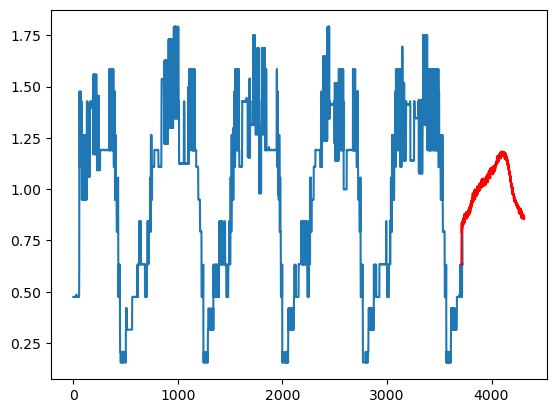

In [13]:
# #plot forecasts
n_test = 10
plot_forecasts(series, forecasts, n_test)

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Train Dataset Evaluation:
t+1 RMSE: 0.116307
t+2 RMSE: 0.140033
t+3 RMSE: 0.147352
t+4 RMSE: 0.148951
t+5 RMSE: 0.157032
t+6 RMSE: 0.161858
t+7 RMSE: 0.168566
t+8 RMSE: 0.170947
t+9 RMSE: 0.175118
t+10 RMSE: 0.180450
t+11 RMSE: 0.181025
t+12 RMSE: 0.185291
t+13 RMSE: 0.190346
t+14 RMSE: 0.195233
t+15 RMSE: 0.199047
t+16 RMSE: 0.203959
t+17 RMSE: 0.206251
t+18 RMSE: 0.209826
t+19 RMSE: 0.214964
t+20 RMSE: 0.219602
t+21 RMSE: 0.224389
t+22 RMSE: 0.230257
t+23 RMSE: 0.231792
t+24 RMSE: 0.239343
t+25 RMSE: 0.243628
t+26 RMSE: 0.246351
t+27 RMSE: 0.251253
t+28 RMSE: 0.258362
t+29 RMSE: 0.259175
t+30 RMSE: 0.264159
t+31 RMSE: 0.268034
t+32 RMSE: 0.272183
t+33 RMSE: 0.274551
t+34 RMSE: 0.277588
t+35 RMSE: 0.280694
t+36 RMSE: 0.283216
t+37 RMSE: 0.290069
t+38 RMSE: 0.291735
t+39 RMSE: 0.296734
t+40 RMSE: 0.300684
t+41 RMSE: 0.302988
t+42 RMSE: 0.306825
t+43 RMSE: 0.310596
t+44 RMSE: 0.314785
t+45 RMSE: 0.318817
t+46 RMSE: 0.324992
t+47 RMSE: 

t+152 RMSE: 0.589400
t+153 RMSE: 0.589591
t+154 RMSE: 0.594325
t+155 RMSE: 0.594202
t+156 RMSE: 0.596659
t+157 RMSE: 0.598788
t+158 RMSE: 0.600225
t+159 RMSE: 0.602680
t+160 RMSE: 0.603804
t+161 RMSE: 0.606473
t+162 RMSE: 0.607877
t+163 RMSE: 0.610103
t+164 RMSE: 0.611341
t+165 RMSE: 0.614388
t+166 RMSE: 0.615747
t+167 RMSE: 0.619542
t+168 RMSE: 0.619163
t+169 RMSE: 0.622299
t+170 RMSE: 0.623606
t+171 RMSE: 0.625504
t+172 RMSE: 0.627518
t+173 RMSE: 0.627862
t+174 RMSE: 0.629216
t+175 RMSE: 0.630519
t+176 RMSE: 0.633697
t+177 RMSE: 0.634087
t+178 RMSE: 0.635916
t+179 RMSE: 0.637680
t+180 RMSE: 0.639099
t+181 RMSE: 0.642029
t+182 RMSE: 0.642347
t+183 RMSE: 0.643535
t+184 RMSE: 0.645959
t+185 RMSE: 0.647464
t+186 RMSE: 0.647704
t+187 RMSE: 0.650955
t+188 RMSE: 0.652268
t+189 RMSE: 0.655546
t+190 RMSE: 0.654743
t+191 RMSE: 0.656939
t+192 RMSE: 0.657124
t+193 RMSE: 0.659494
t+194 RMSE: 0.660984
t+195 RMSE: 0.661112
t+196 RMSE: 0.664888
t+197 RMSE: 0.663446
t+198 RMSE: 0.665574
t+199 RMSE: 0

t+592 RMSE: 0.579581
t+593 RMSE: 0.577639
t+594 RMSE: 0.576978
t+595 RMSE: 0.575575
t+596 RMSE: 0.573365
t+597 RMSE: 0.572899
t+598 RMSE: 0.571072
t+599 RMSE: 0.569337
t+600 RMSE: 0.567116


IndexError: index 3723 is out of bounds for axis 0 with size 3723

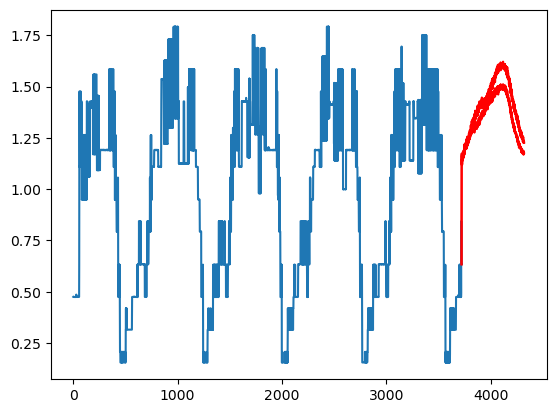

In [10]:
# Evaluate the model fit on the train dataset
train_forecasts = make_forecasts(model, n_batch, train, train, n_lag, n_seq)
train_forecasts = inverse_transform(series, train_forecasts, scaler, len(train) + n_seq - n_lag - 1)
train_actual = [row[n_lag:] for row in train]
train_actual = inverse_transform(series, train_actual, scaler, len(train) + n_seq - n_lag - 1)

# Evaluate and print RMSE for train dataset
print("Train Dataset Evaluation:")
evaluate_forecasts(train_actual, train_forecasts, n_lag, n_seq)

# Plot train forecasts
n_test = 1
plot_forecasts(series, train_forecasts, n_test)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_samples(train_actual, train_forecasts, n_test):
    # Select 3 random samples
    indices = np.random.randint(0, len(train), 3)

    for i in indices:
        actual = train[i]
        forecast = make_forecasts(model, n_batch, train, train, n_lag, n_seq)

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(actual)), actual, label="Actual Data", color='blue')
        plt.plot(range(len(actual), len(actual) + len(forecast)), forecast, label="Forecasted Data", color='red')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.title(f"Sample {i+1}")
        plt.legend()
        plt.show()

# Assuming you already have train_actual and train_forecasts
# You can call the function with n_test as the number of forecasted time steps to plot
n_test = 1  # Change this to the desired number of forecasted time steps to plot
plot_random_samples(train_actual, train_forecasts, n_test)

In [ ]:
# Plot train forecasts
n_test = 1
plot_forecasts(series, train_forecasts, n_test)

## Theory for Hyper Parameters:

Changing each of the configuration parameters will have different effects on the LSTM model and its predictions. Here's an explanation of what each parameter controls:

n_lag: This parameter defines the number of lag observations (input features) to use for predicting the next time step. Increasing n_lag allows the model to consider more past observations, potentially capturing more complex patterns. However, it also increases the dimensionality of the input data and may require more training data to learn effectively.

n_seq: The n_seq parameter determines the number of forecasted observations (output labels) to predict. Increasing n_seq extends the forecast horizon, allowing the model to make predictions further into the future. However, longer forecast horizons are generally more challenging, and the accuracy of the model's predictions may decrease.

n_test: The n_test parameter specifies the number of samples to reserve for testing the model's performance. It determines how many time steps from the end of the dataset will be used for evaluation. Changing n_test allows you to control the size of the test set and assess the model's accuracy on a specific timeframe.

n_epochs: This parameter defines the number of training epochs, which is the number of times the entire training dataset is passed through the LSTM model during training. Increasing n_epochs allows the model to train for a longer duration, potentially improving its accuracy. However, setting n_epochs too high can lead to overfitting if the model starts memorizing the training data without generalizing well to unseen data.

n_batch: The n_batch parameter determines the batch size, which is the number of samples used in each mini-batch during training. Changing n_batch affects the speed and stability of the training process. Larger batch sizes can lead to faster training, but they may also require more memory. Smaller batch sizes provide more frequent updates to the model's weights but may result in slower training progress.

n_neurons: The n_neurons parameter controls the number of neurons (units) in the LSTM layer. Increasing n_neurons can enable the model to capture more complex patterns in the data but also increases the model's capacity and the number of trainable parameters. Too many neurons may lead to overfitting, while too few neurons may limit the model's ability to learn complex relationships.
By adjusting these configuration parameters, you can experiment with different settings to find the optimal values that balance model complexity, training time, and predictive accuracy for your specific dataset and task. It often requires some trial and error to determine the best combination of these parameters.